In [30]:
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier 

# Paths
CSV_PATH = "data/data.csv"   # must contain 'label'
X_PATHS = {
    "tfidf":     "data/text_embeddings_tfidf.npy",
    "minilm":    "data/text_embeddings.npy",
    "detective": "data/detective_emb_384.npy",
}

# Nested-CV settings
OUTER_FOLDS  = 10    
INNER_FOLDS  = 3      
RANDOM_SEED  = 42

# Hyperparameter grid
K_VALUES = [1, 2, 5, 10, 50, 200]
METRICS  = ["cosine", "euclidean"]
WEIGHTS  = ["uniform", "distance"]

# Output
os.makedirs("results", exist_ok=True)



In [31]:
# Labels
df = pd.read_csv(CSV_PATH)
assert "label" in df.columns, "data.csv must contain a 'label' column"
y = df["label"].to_numpy().astype(int)
n = len(y)
print(f"Labels: n={n}, positives={int(y.sum())}")

# Embeddings (must align row-wise with data.csv)
X = {}
for name, path in X_PATHS.items():
    arr = np.load(path)
    assert arr.ndim == 2 and arr.shape[0] == n, f"{name}: {arr.shape} rows != labels {n}"
    X[name] = arr
    print(f"{name}: shape={arr.shape}, dtype={arr.dtype}, NaN={np.isnan(arr).any()}, Inf={np.isinf(arr).any()}")



Labels: n=10000, positives=3545
tfidf: shape=(10000, 384), dtype=float64, NaN=False, Inf=False
minilm: shape=(10000, 384), dtype=float32, NaN=False, Inf=False
detective: shape=(10000, 384), dtype=float32, NaN=False, Inf=False


In [32]:
def confusion_matrix_binary(y_true, y_pred):
    y_true = y_true.astype(int); y_pred = y_pred.astype(int)
    tp = int(((y_true==1) & (y_pred==1)).sum())
    tn = int(((y_true==0) & (y_pred==0)).sum())
    fp = int(((y_true==0) & (y_pred==1)).sum())
    fn = int(((y_true==1) & (y_pred==0)).sum())
    return tn, fp, fn, tp

def accuracy(y_true, y_pred):
    return float((y_true == y_pred).mean())

def precision_recall_f1(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix_binary(y_true, y_pred)
    prec = tp / (tp + fp) if (tp+fp) > 0 else 0.0
    rec  = tp / (tp + fn) if (tp+fn) > 0 else 0.0
    f1   = 2*prec*rec / (prec + rec) if (prec + rec) > 0 else 0.0
    return prec, rec, f1

def roc_auc_score_binary(y_true, scores):
    """
    AUC via rank-sum (no external metrics).
    y_true ∈ {0,1}; scores: higher = more likely positive.
    """
    y_true = y_true.astype(int)
    pos = int(y_true.sum()); neg = len(y_true) - pos
    if pos == 0 or neg == 0:
        return np.nan
    order = np.argsort(scores)
    ranks = np.empty_like(order); ranks[order] = np.arange(1, len(scores)+1)
    rank_sum_pos = int(ranks[y_true == 1].sum())
    U = rank_sum_pos - pos*(pos+1)/2
    return float(U / (pos*neg))



In [33]:
def kfold_indices(n_samples, k=5, seed=42):
    """
    Returns list of (train_idx, test_idx) tuples using plain K-Fold.
    We shuffle once, then split into k contiguous folds.
    """
    rng = np.random.default_rng(seed)
    idx = np.arange(n_samples)
    rng.shuffle(idx)
    folds = np.array_split(idx, k)

    all_idx = np.arange(n_samples)
    splits = []
    for i in range(k):
        test_idx = folds[i]
        train_idx = np.setdiff1d(all_idx, test_idx, assume_unique=False)
        splits.append((train_idx, test_idx))
    return splits

def kfold_indices_on_subset(n_subset, k=3, seed=42):
    """
    Same but for a subset range (0..n_subset-1). Used for inner CV on outer-train slice.
    """
    return kfold_indices(n_subset, k=k, seed=seed)


In [34]:
def fit_predict_knn(X_train, y_train, X_test, k=5, metric="cosine", weights="uniform"):
    if metric == "cosine":
        # cosine with brute is safest
        knn = KNeighborsClassifier(n_neighbors=k, metric="cosine", weights=weights, algorithm="brute")
    elif metric == "euclidean":
        knn = KNeighborsClassifier(n_neighbors=k, metric="euclidean", weights=weights)
    else:
        raise ValueError("metric must be 'cosine' or 'euclidean'")
    knn.fit(X_train, y_train)
    scores = knn.predict_proba(X_test)[:, 1]
    y_pred = (scores >= 0.5).astype(int)
    return y_pred, scores


In [35]:
def inner_cv_tune_train_only(Xtr, ytr, k_inner=3, seed=42):
    """
    Tune over K_VALUES × METRICS × WEIGHTS using inner K-fold on outer-train set.
    Objective: mean F1 across inner folds (threshold 0.5).
    Returns (best_params, best_f1).
    """
    inner_splits = kfold_indices_on_subset(len(ytr), k=k_inner, seed=seed)
    best = {"score": -1.0, "params": None}

    for K in K_VALUES:
        for metric in METRICS:
            for weights in WEIGHTS:
                f1s = []
                for tr_sub_idx, va_sub_idx in inner_splits:
                    X_tr_sub, y_tr_sub = Xtr[tr_sub_idx], ytr[tr_sub_idx]
                    X_va_sub, y_va_sub = Xtr[va_sub_idx], ytr[va_sub_idx]
                    y_hat, _ = fit_predict_knn(X_tr_sub, y_tr_sub, X_va_sub,
                                               k=K, metric=metric, weights=weights)
                    _, _, f1 = precision_recall_f1(y_va_sub, y_hat)
                    f1s.append(f1)
                mean_f1 = float(np.mean(f1s))
                if mean_f1 > best["score"]:
                    best = {"score": mean_f1, "params": {"k": K, "metric": metric, "weights": weights}}
    return best["params"], best["score"]


In [36]:
def nested_cv_embedding(Xmat, y, outer_folds=10, inner_folds=3, seed=42, verbose=True):
    """
    Outer 10-fold; for each outer-train, run inner 3-fold to tune.
    Returns per-fold metrics and list of chosen params (length = outer_folds).
    """
    outer = kfold_indices(len(y), k=outer_folds, seed=seed)
    per_fold = []
    chosen_params = []

    for f, (tr_idx, te_idx) in enumerate(outer, 1):
        Xtr, ytr = Xmat[tr_idx], y[tr_idx]
        Xte, yte = Xmat[te_idx], y[te_idx]

        # Inner tune (seed varied by fold)
        params, inner_best_f1 = inner_cv_tune_train_only(Xtr, ytr, k_inner=inner_folds, seed=seed + f)
        chosen_params.append(params)

        # Fit on full outer-train with best params; evaluate on outer-test
        y_pred, scores = fit_predict_knn(Xtr, ytr, Xte,
                                         k=params["k"], metric=params["metric"], weights=params["weights"])

        tn, fp, fn, tp = confusion_matrix_binary(yte, y_pred)
        acc = accuracy(yte, y_pred)
        prec, rec, f1 = precision_recall_f1(yte, y_pred)
        auc = roc_auc_score_binary(yte, scores)

        per_fold.append({
            "fold": f, "tn": tn, "fp": fp, "fn": fn, "tp": tp,
            "acc": acc, "prec": prec, "rec": rec, "f1": f1, "auc": auc,
            "k": params["k"], "metric": params["metric"], "weights": params["weights"],
            "inner_best_f1": inner_best_f1
        })

        if verbose:
            print(f"[outer {f:02d}] k={params['k']:>2}, {params['metric'][:3]}, {params['weights'][:3]} | "
                  f"acc={acc:.4f}, f1={f1:.4f}, auc={auc:.4f}")
    return per_fold, chosen_params


In [ ]:
all_results = {}
for name, Xmat in X.items():
    print("\n===== ", name.upper(), f"(outer={OUTER_FOLDS}, inner={INNER_FOLDS}) =====")
    folds, params = nested_cv_embedding(Xmat, y, outer_folds=OUTER_FOLDS, inner_folds=INNER_FOLDS,
                                        seed=RANDOM_SEED, verbose=True)
    folds_df = pd.DataFrame(folds)
    all_results[name] = {"folds": folds_df, "params": params}
    out_csv = f"results/{name}_nestedcv_outer{OUTER_FOLDS}_inner{INNER_FOLDS}.csv"
    # folds_df.to_csv(out_csv, index=False)
    # print("Saved:", out_csv)



=====  TFIDF (outer=10, inner=3) =====


In [ ]:
def mean_std(a):
    a = np.array(a, dtype=float)
    if a.size == 0:
        return np.nan, np.nan
    return float(a.mean()), float(a.std(ddof=1)) if a.size > 1 else 0.0

summary_rows = []
k_choice_counts = {}
mw_choice_counts = {}

for name, res in all_results.items():
    df_fold = res["folds"]
    acc_m, acc_s = mean_std(df_fold["acc"])
    pre_m, pre_s = mean_std(df_fold["prec"])
    rec_m, rec_s = mean_std(df_fold["rec"])
    f1_m,  f1_s  = mean_std(df_fold["f1"])
    # AUC may be NaN if a class is missing in a fold; ignore NaNs
    auc_m, auc_s = mean_std(df_fold["auc"][df_fold["auc"].notna()])

    summary_rows.append({
        "embedding": name,
        "acc_mean": acc_m, "acc_std": acc_s,
        "prec_mean": pre_m, "prec_std": pre_s,
        "rec_mean": rec_m, "rec_std": rec_s,
        "f1_mean":  f1_m,  "f1_std":  f1_s,
        "auc_mean": auc_m, "auc_std": auc_s
    })

    k_choice_counts[name] = Counter(df_fold["k"])
    mw_choice_counts[name] = Counter(zip(df_fold["metric"], df_fold["weights"]))

print(summary_rows)
summary_df = pd.DataFrame(summary_rows).sort_values("f1_mean", ascending=False).reset_index(drop=True)
summary_path = f"results/nestedcv_summary_outer{OUTER_FOLDS}_inner{INNER_FOLDS}.csv"
summary_df.to_csv(summary_path, index=False)
summary_df


[]


KeyError: 'f1_mean'

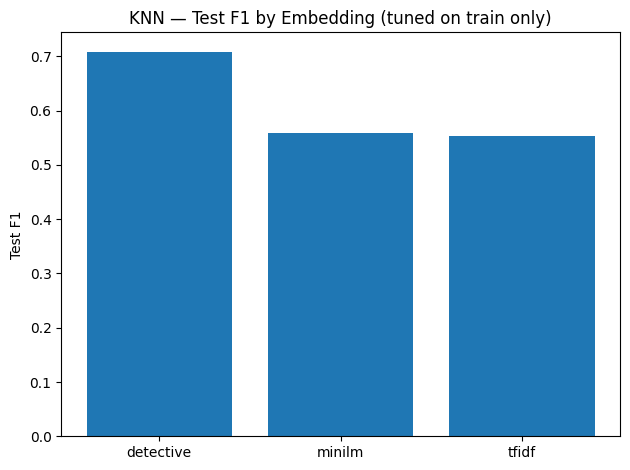

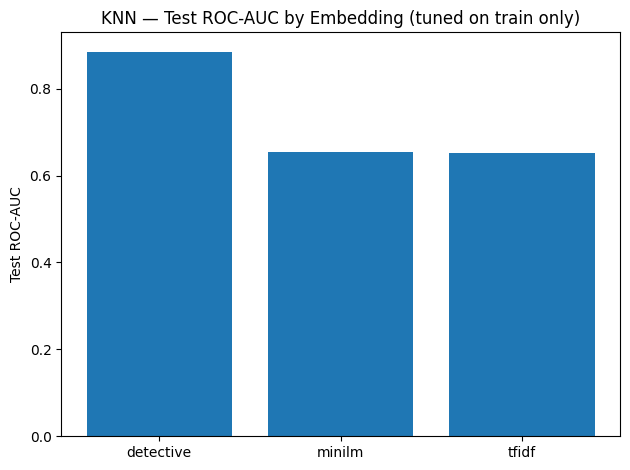

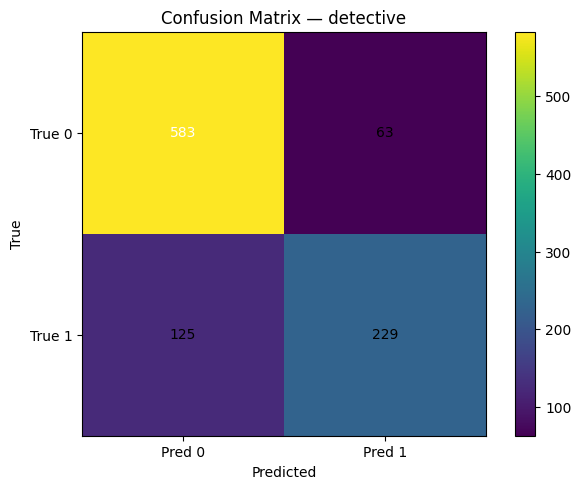

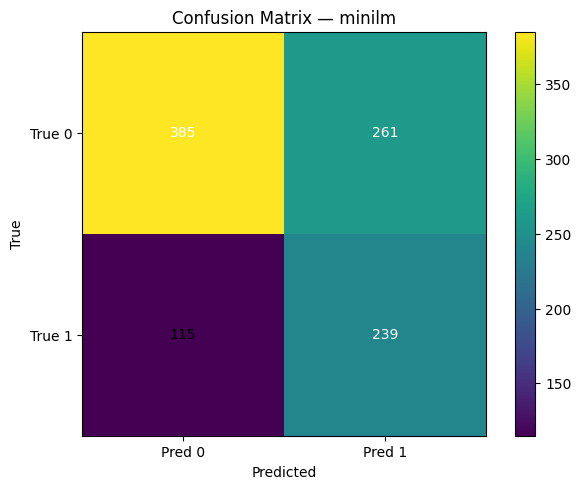

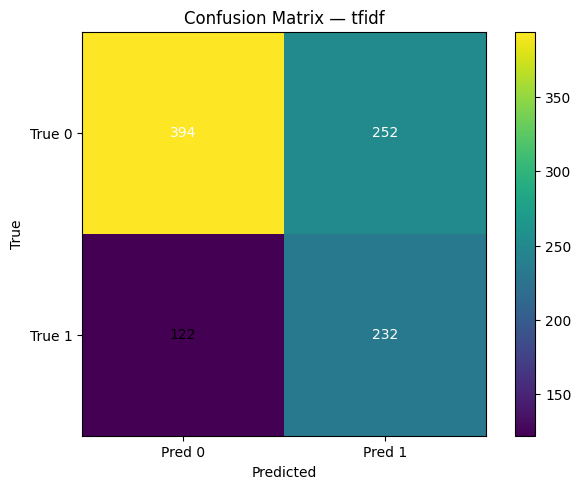

In [ ]:
# F1 bar chart
plt.figure()
x = np.arange(len(summary_df))
plt.bar(x, summary_df["f1_mean"], yerr=summary_df["f1_std"])
plt.xticks(x, summary_df["embedding"])
plt.ylabel("F1 (outer-CV mean ± std)")
plt.title(f"KNN — Nested CV F1 (outer={OUTER_FOLDS}, inner={INNER_FOLDS})")
plt.tight_layout(); plt.show()

# AUC bar chart
plt.figure()
x = np.arange(len(summary_df))
auc_means = np.nan_to_num(summary_df["auc_mean"].values, nan=0.0)
auc_errs  = np.nan_to_num(summary_df["auc_std"].values,  nan=0.0)
plt.bar(x, auc_means, yerr=auc_errs)
plt.xticks(x, summary_df["embedding"])
plt.ylabel("ROC-AUC (outer-CV mean ± std)")
plt.title(f"KNN — Nested CV AUC (outer={OUTER_FOLDS}, inner={INNER_FOLDS})")
plt.tight_layout(); plt.show()


for name in X.keys():
    counts = k_choice_counts[name]
    ks_sorted = sorted(K_VALUES)
    freqs = [counts.get(k, 0) for k in ks_sorted]

    plt.figure()
    x = np.arange(len(ks_sorted))
    plt.bar(x, freqs)
    plt.xticks(x, ks_sorted)
    plt.ylabel("Outer-fold selections")
    plt.xlabel("k")
    plt.title(f"Selected k frequency — {name} (outer={OUTER_FOLDS})")
    plt.tight_layout(); plt.show()


pairs = [(m, w) for m in METRICS for w in WEIGHTS]

for name in X.keys():
    counts = mw_choice_counts[name]
    mat = np.zeros((len(METRICS), len(WEIGHTS)), dtype=int)
    for (m, w), c in counts.items():
        mi = METRICS.index(m); wi = WEIGHTS.index(w)
        mat[mi, wi] = c

    plt.figure()
    plt.imshow(mat, interpolation='nearest')
    plt.title(f"(metric × weights) selections — {name}")
    plt.colorbar()
    plt.xticks(np.arange(len(WEIGHTS)), WEIGHTS)
    plt.yticks(np.arange(len(METRICS)), METRICS)
    for i in range(len(METRICS)):
        for j in range(len(WEIGHTS)):
            val = mat[i, j]
            plt.text(j, i, val, ha="center", va="center",
                     color="white" if val > (mat.max()/2) else "black")
    plt.tight_layout(); plt.show()
